# Customer Subscription Analysis

In [461]:
#Import libraries
import sqlite3 #for SQLite database connection
import pandas as pd #data manipulation and analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [463]:
#Read in Data
df_cases = pd.read_csv("customer_cases.csv")
df_customer_info = pd.read_csv("customer_info.csv")
df_signup_cancel = pd.read_csv("customer_product.csv")
df_products = pd.read_csv("product_info.csv")

In [101]:
#Create SQLite database
conn = sqlite3.connect('subscriptions.db')
cursor = conn.cursor()

df_cases.to_sql('cases', conn, if_exists ='replace', index=False)
df_signup_cancel.to_sql('signup_cancel', conn, if_exists = 'replace', index=False)
df_products.to_sql('products', conn, if_exists ='replace', index=False)
df_customer_info.to_sql('customers', conn, if_exists ='replace', index=False)
print("tables successfully uploaded to SQLite")

tables successfully uploaded to SQLite


In [176]:
#Check table names in the SQL database
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("tables in the database:", tables)
conn.commit()

tables in the database: [('cases',), ('signup_cancel',), ('products',), ('customers',)]


In [178]:
#Check first few rows of each table
for table in ["cases", "signup_cancel", "customers", "products"]:
    query = f"SELECT * FROM {table} LIMIT 5;"
    print(f"First rows of {table}:")
    display(pd.read_sql_query(query, conn))

First rows of cases:


,Unnamed: 0,case_id,date_time,customer_id,channel,reason
0,1,CC101,2017-01-01 10:32:03,C2448,phone,signup
1,2,CC102,2017-01-01 11:35:47,C2449,phone,signup
2,3,CC103,2017-01-01 11:37:09,C2450,phone,signup
3,4,CC104,2017-01-01 13:28:14,C2451,phone,signup
4,5,CC105,2017-01-01 13:52:22,C2452,phone,signup


First rows of signup_cancel:


,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time
0,1,C2448,prd_1,2017-01-01 10:35:09,None
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,4,C2451,prd_2,2017-01-01 13:32:08,None
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


First rows of customers:


,Unnamed: 0,customer_id,age,gender
0,1,C2448,76,female
1,2,C2449,61,male
2,3,C2450,58,female
3,4,C2451,62,female
4,5,C2452,71,male


First rows of products:


,product_id,name,price,billing_cycle
0,prd_1,annual_subscription,1200,12
1,prd_2,monthly_subscription,125,1


## 1. Data Preprocessing 
Chcek for missing values

In [339]:
df_cases.isnull().sum()
df_customer_info.isnull().sum()
df_products.isnull().sum()
df_signup_cancel.isnull().sum() #369k missing cancel dates values

Unnamed: 0               0
customer_id              0
product                  0
signup_date_time         0
cancel_date_time    396447
dtype: int64

We can assume the missing cancellation dates indicate the customer has not cancelled their subscription. Lrt's create new column for active and inactive customers. 

In [465]:
df_signup_cancel['status'] = df_signup_cancel['cancel_date_time'].isna().map({True: 'Active', False: 'Inactive'})
df_signup_cancel.head()

,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time,status
0,1,C2448,prd_1,2017-01-01 10:35:09,NaN,Active
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02,Inactive
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55,Inactive
3,4,C2451,prd_2,2017-01-01 13:32:08,NaN,Active
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01,Inactive


Lets remove the extra column, its unecesaary

In [558]:
# Removes first column
def remove_first_column(df):
    first_column = df.columns[0]
    return df.drop(columns = first_column, axis=1)

df_cases = remove_first_column(df_cases)
df_signup_cancel = remove_first_column(df_signup_cancel)
df_customer_info = remove_first_column(df_customer_info)

Chcek structure and statistics

In [277]:
df_cases.describe()
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330512 entries, 0 to 330511
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   330512 non-null  int64 
 1   case_id      330512 non-null  object
 2   date_time    330512 non-null  object
 3   customer_id  330512 non-null  object
 4   channel      330512 non-null  object
 5   reason       330512 non-null  object
dtypes: int64(1), object(5)
memory usage: 15.1+ MB


Convert date and time to correct data type

In [467]:
# Converts date column to correct format
date_columns = ['signup_date_time', 'cancel_date_time', 'date_time']

def convert_date_time(df, column_list):
    for column in column_list:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column])
    return df

df_signup_cancel = convert_date_time(df_signup_cancel, date_columns)
df_cases = convert_date_time(df_cases, date_columns)
df_signup_cancel.dtypes

Unnamed: 0                   int64
customer_id                 object
product                     object
signup_date_time    datetime64[ns]
cancel_date_time    datetime64[ns]
status                      object
dtype: object

In [469]:
df_cases = df_cases.drop_duplicates()
df_signup_cancel = df_signup_cancel.drop_duplicates()
df_customer_info = df_customer_info.drop_duplicates()
df_products = df_products.drop_duplicates()

### SQL Exploratory Data Analysis

In [144]:
query = '''
    SELECT *
    FROM signup_cancel s
    LEFT JOIN customers c ON c.customer_id = s.customer_id
    WHERE cancel_date_time IS NULL
    ORDER BY c.customer_id
    LIMIT 5
'''
pd.read_sql_query(query, conn)

,COUNT(*)
0,1


In [154]:
query = '''
    SELECT COUNT(*) AS total_customers
    FROM customers
'''
pd.read_sql_query(query, conn)

,total_customers
0,508932


In [164]:
query = '''
    SELECT COUNT(*) AS cancelled_customers
    FROM signup_cancel
    WHERE cancel_date_time IS NOT NULL
'''
pd.read_sql_query(query, conn)

,cancelled_customers
0,112485


In [190]:
query = '''
    SELECT channel, count(*) AS total_cases
    FROM cases
    GROUP BY channel
'''
pd.read_sql_query(query, conn)

,channel,total_cases
0,email,43672
1,phone,286840


In [258]:
query = '''
    SELECT reason, channel, count(*) AS total_cases
    FROM cases
    GROUP BY reason, channel
'''
pd.read_sql_query(query, conn)

,reason,channel,total_cases
0,signup,phone,129527
1,support,email,43672
2,support,phone,157313


In [206]:
query = '''
    SELECT gender, count(*) AS customers
    FROM customers
    GROUP BY gender
    ORDER BY customers DESC
'''
pd.read_sql_query(query, conn)

,gender,customers
0,male,309930
1,female,199002


In [210]:
query = '''
    SELECT age, count(*) AS customers
    FROM customers
    GROUP BY age
    ORDER BY customers DESC
    LIMIT 5
'''
pd.read_sql_query(query, conn)

,age,customers
0,60,24483
1,61,24380
2,59,24298
3,58,24126
4,62,23645


In [256]:
#Total revenue, total customers, and avg age of 'current' customers
query = '''
    SELECT p.name, avg(c.age) AS avg_age, count(c.customer_id) AS total_customers,
        SUM(p.price) AS total_revenue
    FROM signup_cancel s
    JOIN products p ON s.product = p.product_id
    JOIN customers c ON s.customer_id = c.customer_id
    WHERE s.cancel_date_time IS NOT NULL
    GROUP BY p.name
'''
pd.read_sql_query(query, conn)

,name,avg_age,total_customers,total_revenue
0,annual_subscription,58.470121,69682,83618400
1,monthly_subscription,58.340700,42803,5350375


### Python EDA 

C:\Anaconda_Stuff\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


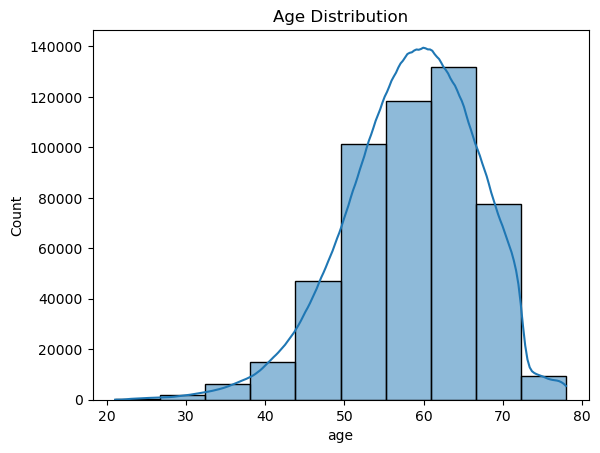

In [471]:
sns.histplot(df_customer_info['age'], bins=10, kde=True)
plt.title('Age Distribution')
plt.show()

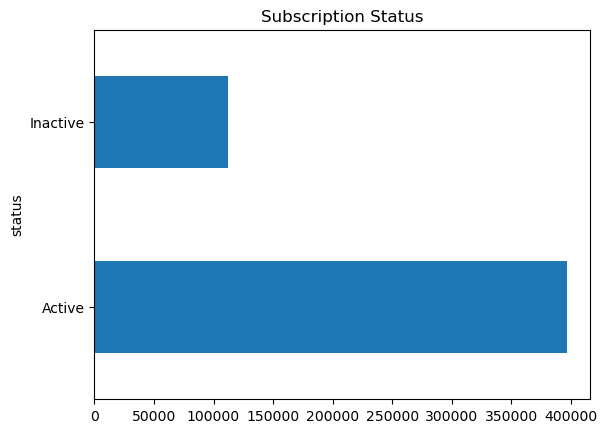

In [480]:
df_signup_cancel['status'].value_counts().plot(kind='barh')
plt.title('Subscription Status')
plt.show()

In [494]:
pivot = df_signup_cancel.pivot_table(
    index='product', columns='status', aggfunc='size', fill_value=0)

print(pivot)

status   Active  Inactive
product                  
prd_1    255967     69682
prd_2    140480     42803


In [550]:
df_signup_cancel[['customer_id', 'status', 'product']].groupby(['product', 'status']).count()

customer_id
product status               
prd_1   Active         255967
        Inactive        69682
prd_2   Active         140480
        Inactive        42803

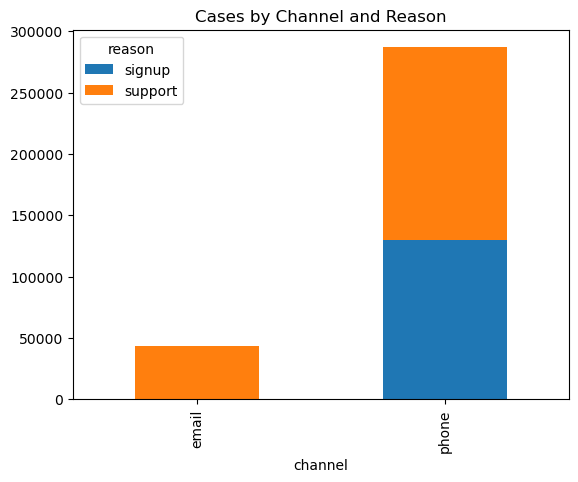

In [516]:
channel_reason = df_cases.groupby(['channel', 'reason']).size().unstack()
channel_reason.plot(kind='bar', stacked=True)
plt.title('Cases by Channel and Reason')
plt.show()

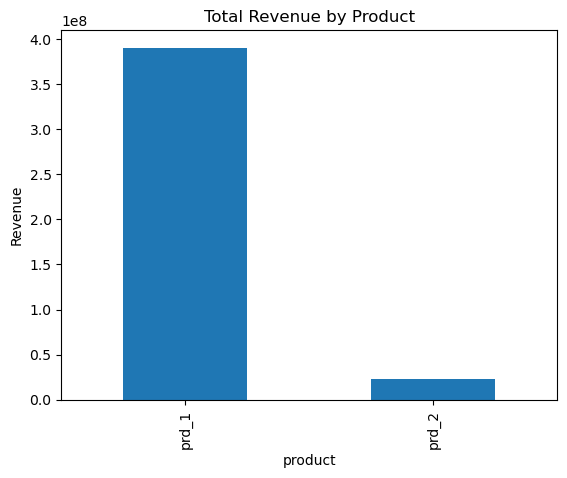

,product_id,name,price,billing_cycle
0,prd_1,annual_subscription,1200,12
1,prd_2,monthly_subscription,125,1


In [540]:
revenue = pd.merge(df_signup_cancel, df_products, left_on='product', right_on='product_id')
revenue['total_revenue'] = revenue['price']

revenue_by_product = revenue.groupby('product')['total_revenue'].sum()
revenue_by_product.plot(kind='bar')
plt.title('Total Revenue by Product')
plt.ylabel('Revenue')
plt.show()
df_products

## Times Series Analysis

In [124]:
# df_cases
# df_customer_info
# df_signup_cancel
# df_products

,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time
0,1,C2448,prd_1,2017-01-01 10:35:09,NaN
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,4,C2451,prd_2,2017-01-01 13:32:08,NaN
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01
...,...,...,...,...,...
508927,508928,C511375,prd_2,2021-12-31 18:37:58,NaN
508928,508929,C511376,prd_2,2021-12-31 18:42:00,NaN
508929,508930,C511377,prd_2,2021-12-31 18:50:53,NaN
508930,508931,C511378,prd_2,2021-12-31 19:00:38,NaN


In [643]:
# df_cases.sort_values(by = 'date_time', ascending = False)
# merged_df = pd.merge(df_cases, df_customer_info, on= 'customer_id', how='left')

# merged_df = pd.merge(merged_df, df_signup_cancel, on= 'customer_id', how='left')
# merged_df = pd.merge(merged_df, df_products, left_on='product', right_on= 'product_id')
# merged_df

The main research question is to predict mobthly revenue for the next 6 months. I will use time series analysis to make predictions. 

In [1076]:
# Forecast Monthly Revenue
revenue_df = pd.merge(df_signup_cancel, df_products, left_on='product', right_on= 'product_id')
revenue_df['revenue'] = revenue_df['price']

revenue_df['month'] = revenue_df['signup_date_time'].dt.to_period('M') #extract month
revenue_df['month'] = revenue_df['month'].dt.to_timestamp() #convert back to dt
monthly_revenue = revenue_df.groupby('month')[['revenue']].sum()

monthly_revenue.head()

,revenue
month,
2017-01-01,3796100
2017-02-01,3554150
2017-03-01,4017700
2017-04-01,3633750
2017-05-01,3722150


<Axes: title={'center': 'Monthly Revenue'}, xlabel='month'>

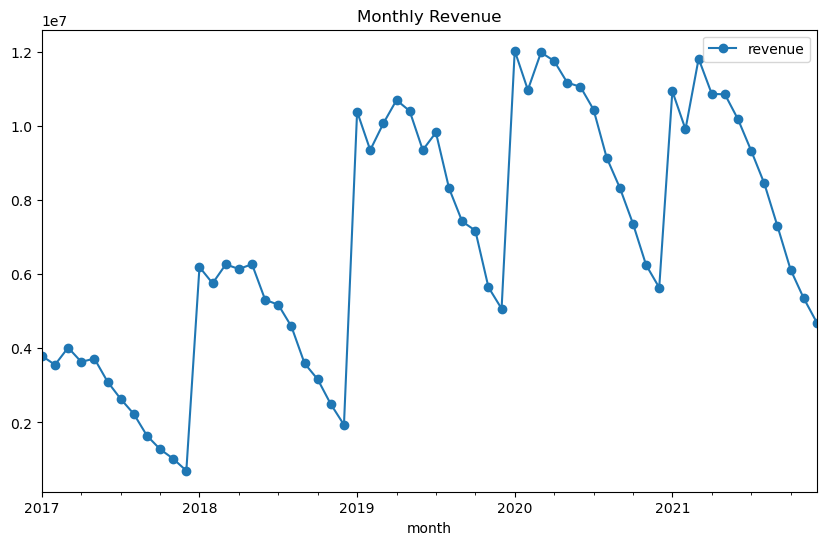

In [1017]:
monthly_revenue.plot(title="Monthly Revenue", figsize=(10, 6), marker="o")

We can see there is a clear upward trend. The overall trend is moving upward as time goes on. There is also seasonilty in the data, there appears to be patterns at a fixed interval. Let's now plot the decomposed data.

#### Check Stationarity

In times-series analysis our data should be stationarity. We can test if out data is staionary using two differing methods, plotting the rolling statistics or the adfuller test. Below i created a function to handle this. 

I'm getting a warning for handling infinity values. To make my code clearer, i will suppress the warnings. 

In [1048]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

ADF Statistic: -3.756809229098826,
P-value: 0.003381448015584388
1% -3.5745892596209488
5% -2.9239543084490744
10% -2.6000391840277777
None


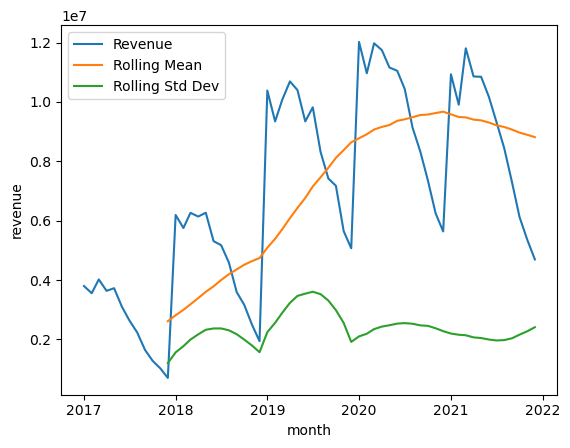

In [1078]:
from statsmodels.tsa.stattools import adfuller

def test_stationaity(df, column):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=[column], inplace=True)
    
    adfuller_test = adfuller(df[column])
    print(f"ADF Statistic: {adfuller_test[0]},\nP-value: {adfuller_test[1]}")

    for k, v in adfuller_test[4].items():
        print(k, v)
        
    df['rolling_mean'] = df[column].rolling(window=12).mean()
    df['rolling_std'] = df[column].rolling(window=12).std()

    sns.lineplot(data=df, x=df.index, y=df[column], label="Revenue")
    sns.lineplot(data=df, x=df.index, y=df['rolling_mean'], label="Rolling Mean")
    sns.lineplot(data=df, x=df.index, y=df['rolling_std'],label="Rolling Std Dev")
    
print(test_stationaity(monthly_revenue, 'revenue'))

The rolling mean and the rolling standard deviation lines are not constant, so this proves our data is not stationary. It shows significant fluctuations and some upward trends. There is a clear trend observed in the roloing mean., smooth curve. the rolling stdev shows variance that is not contanst, suggesgint volatity. The data is clearly non-stationary due to the trends and fluctuations in both the mean and variance.

According to the ADF test, 

In [1059]:
monthly_revenue.head(12)

,revenue,rolling_mean,rolling_std,shift,diff
month,,,,,
2017-02-01 00:00:00,3554150.0,NaN,NaN,3796100.0,-241950.0
2017-03-01 00:00:00,4017700.0,NaN,NaN,3554150.0,463550.0
2017-04-01 00:00:00,3633750.0,NaN,NaN,4017700.0,-383950.0
2017-05-01 00:00:00,3722150.0,NaN,NaN,3633750.0,88400.0
2017-06-01 00:00:00,3099975.0,NaN,NaN,3722150.0,-622175.0
2017-07-01 00:00:00,2635100.0,NaN,NaN,3099975.0,-464875.0
2017-08-01 00:00:00,2230150.0,NaN,NaN,2635100.0,-404950.0
2017-09-01 00:00:00,1644650.0,NaN,NaN,2230150.0,-585500.0
2017-10-01 00:00:00,1279950.0,NaN,NaN,1644650.0,-364700.0


#### Transformation

Since our data is not stationary, we must transfrom it until it is stationary. I will use different combinations of difference, log, squared, or cubed root to transform the data. I will reuse my statinoarity function i created above to keep checking if it becomes staionary. 

In [1080]:
monthly_revenue['diff'] = monthly_revenue['revenue'] - monthly_revenue['revenue'].shift()
# monthly_revenue['diff2'] = monthly_revenue['revenue'].diff()

monthly_revenue.head()

,revenue,rolling_mean,rolling_std,diff,diff2
month,,,,,
2017-01-01,3796100,NaN,NaN,NaN,NaN
2017-02-01,3554150,NaN,NaN,-241950.0,-241950.0
2017-03-01,4017700,NaN,NaN,463550.0,463550.0
2017-04-01,3633750,NaN,NaN,-383950.0,-383950.0
2017-05-01,3722150,NaN,NaN,88400.0,88400.0


ADF Statistic: -0.8643247302718239,
P-value: 0.7994937253996794
1% -3.5778480370438146
5% -2.925338105429433
10% -2.6007735310095064
None


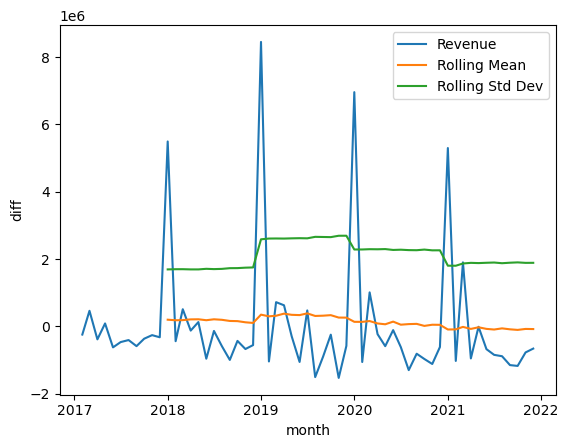

In [1082]:
print(test_stationaity(monthly_revenue, 'diff'))

Fluctuations in revenu appear more stable compared to the original data, indicating improved stationarity. The rolling mean and rolling standard deviation is nearly flat, confirming its stable over time. 

However, According to the ADF test The differencing operation did not make the series stationary. The ADF statistic is significantly greater (less negative) than all critical values (1%, 5%, 10% levels). This indicates that the null hypothesis of non-stationarity cannot be rejected. The p-value is greater than 0.05, meaning there is insufficient evidence to reject the null hypothesis of non-stationarity.

This could be due to Remaining Trends and potemtial seasonilty in the data. Next i''l apply Apply Seasonal Differencing. 

In [ ]:
# Restore warnings 
warnings.filterwarnings("default")

In [1091]:
monthly_revenue['diff_seasonal'] = monthly_revenue['revenue'] - monthly_revenue['revenue'].shift(12)
monthly_revenue['diff_combined'] = monthly_revenue['diff_seasonal'] - monthly_revenue['diff_seasonal'].shift()

monthly_revenue['log_revenue'] = np.log(monthly_revenue['revenue'])
monthly_revenue['log_diff'] = monthly_revenue['log_revenue'] - monthly_revenue['log_revenue'].shift()
monthly_revenue

,revenue,rolling_mean,rolling_std,diff,diff2,diff_seasonal,diff_combined,log_revenue,log_diff
month,,,,,,,,,
2017-02-01,3554150,NaN,NaN,-241950.0,-241950.0,NaN,NaN,15.083626,NaN
2017-03-01,4017700,NaN,NaN,463550.0,463550.0,NaN,NaN,15.206220,0.122594
2017-04-01,3633750,NaN,NaN,-383950.0,-383950.0,NaN,NaN,15.105776,-0.100444
2017-05-01,3722150,NaN,NaN,88400.0,88400.0,NaN,NaN,15.129812,0.024036
2017-06-01,3099975,NaN,NaN,-622175.0,-622175.0,NaN,NaN,14.946905,-0.182907
2017-07-01,2635100,NaN,NaN,-464875.0,-464875.0,NaN,NaN,14.784432,-0.162473
2017-08-01,2230150,NaN,NaN,-404950.0,-404950.0,NaN,NaN,14.617579,-0.166852
2017-09-01,1644650,NaN,NaN,-585500.0,-585500.0,NaN,NaN,14.313038,-0.304541
2017-10-01,1279950,NaN,NaN,-364700.0,-364700.0,NaN,NaN,14.062332,-0.250707


ADF Statistic: -0.8303454976550522,
P-value: 0.8100454156047566
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338
None


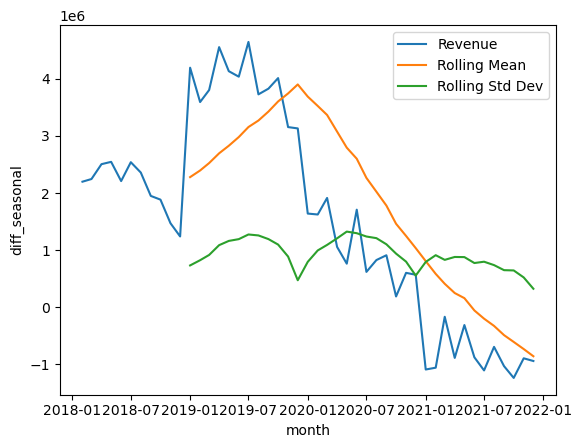

In [1093]:
print(test_stationaity(monthly_revenue, 'diff_seasonal'))

**Non-stationariy**. Seasonal differencing alone did not make the series stationary

ADF Statistic: -3.1088249665706136,
P-value: 0.025906957331614532
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338
None


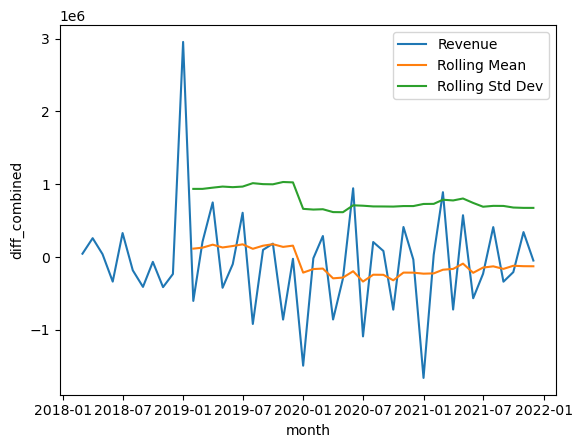

In [1095]:
print(test_stationaity(monthly_revenue, 'diff_combined'))

**Weak stationay**. The p-value (0.0259) is below 0.05, indicating the series is weakly stationary. Combined differencing improved stationarity, but it is not strongly stationary. Further transformations needed

ADF Statistic: -7.442173404575533,
P-value: 5.965982243505494e-11
1% -3.584828853223594
5% -2.9282991495198907
10% -2.6023438271604937
None


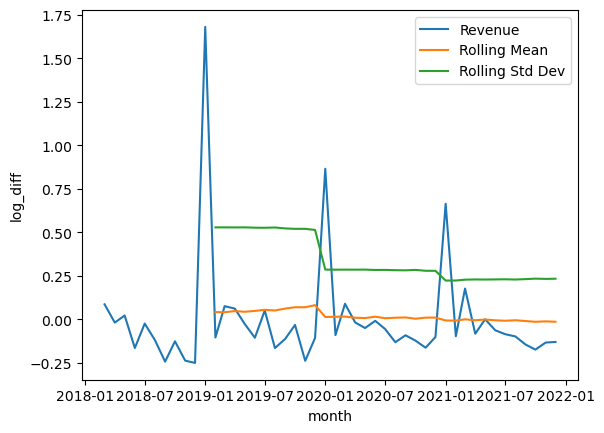

In [1097]:
print(test_stationaity(monthly_revenue, 'log_diff'))

**Strong stationaryity** Log transformation followed by differencing successfully made the series stationary. The ADF Statistic is much lower (more negative) than all critical values (1%, 5%, and 10%), indicating we reject the null hypothesis at all confidence levels.
The p-value is effectively 0, meaning the series is strongly stationary.

#### Modeling - ARIMA Model